In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
%matplotlib inline

# <span style="color:red">Pending To-Do's</span>
- remove outliers and evaluate summaries again

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performance like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx') # road race one
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx') # time trial one
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx') # road race two
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx') # time trial two

### 1. Familiarising with the data

In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


In [4]:
rr_2019.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,NaN
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0


In [5]:
tt_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.000000,NaN
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,11.089134,2.0
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,0.991282,6.0
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,0.249655,23.0
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,5.742071,1.0


In [6]:
tt_2019.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,NaN
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0


### 2. What is the overall distance travelled for each of the rides? What are the average speeds etc. Provide a summary for each ride. Additional features of interest are total time needed and total elevation gain.

#### 2.1 Road Race 2016

In [14]:
# overall statistical summary for road race one in 2016

rr_2016.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2821.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,34.933085,1.843318
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,10.738677,1.692364
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,1.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,26.656312,1.000000
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,33.307339,1.000000
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,42.871885,2.000000
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,92.749036,9.000000


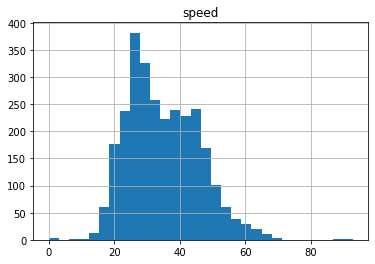

In [128]:
rr16_speed_distribution = rr_2016.hist('speed', bins=30, histtype='stepfilled')

In [95]:
# show relevant features

rr_2016_distance = rr_2016["distance"].sum()
rr_2016_time = (rr_2016["timedelta"].sum())/60
rr_2016_elevation = rr_2016["elevation_gain"].sum()
rr_2016_speed = rr_2016["speed"].mean()
rr_2016_minkm = (rr_2016_time)/rr_2016_distance


print("Total distance travelled for road race in 2016 is:\t", round(rr_2016_distance, 2), "km")
print("Total time needed for road race in 2016 is:\t\t", round(rr_2016_time, 2), "minutes")
print("Total elevation gain for road race in 2016 is:\t\t", round(rr_2016_elevation, 2), "m")
print("The mean speed for road race in 2016 is:\t\t", round(rr_2016_speed, 2), "km/h")
print("The mean time per kilometer for road race in 2016 is:\t", round(rr_2016_minkm, 2), "min/km")

Total distance travelled for road race in 2016 is:	 49.05 km
Total time needed for road race in 2016 is:		 86.67 minutes
Total elevation gain for road race in 2016 is:		 -10.6 m
The mean speed for road race in 2016 is:		 34.93 km/h
The mean time per kilometer for road race in 2016 is:	 1.77 min/km


In [73]:
# add simple moving average of speed as a column 

rr_2016["speed_SMA"] = rr_2016["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
rr_2016.head()


,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN,0.000000
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0,5.888510
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0,9.384018
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0,12.348989
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0,14.559434


#### 2.2 Road Race 2019

In [27]:
# overall statistical summary for road race two in 2019

rr_2019.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5502.0
mean,-33.371644,151.225232,243.243576,5.997819,213.617845,70.004906,138.998546,0.009411,0.000254,33.879861,1.0
std,0.030592,0.006142,30.197981,0.806414,144.123686,29.869938,16.184123,0.002459,0.347322,8.853503,0.0
min,-33.422174,151.211507,185.200000,0.000000,0.000000,0.000000,71.000000,0.000000,-2.000000,0.000000,1.0
25%,-33.396939,151.221591,219.600000,5.000000,104.000000,66.000000,129.000000,0.007839,-0.200000,28.219962,1.0
50%,-33.373835,151.227064,236.000000,6.000000,212.000000,81.000000,142.000000,0.009178,0.000000,33.041360,1.0
75%,-33.344994,151.229977,269.600000,7.000000,308.000000,89.000000,152.000000,0.010733,0.200000,38.640026,1.0
max,-33.316865,151.235094,310.400000,7.000000,785.000000,120.000000,170.000000,0.019547,1.000000,70.370469,1.0


Note the following:<br/>
- The maximum value of 785 Watt power seems high and requires further investigation.

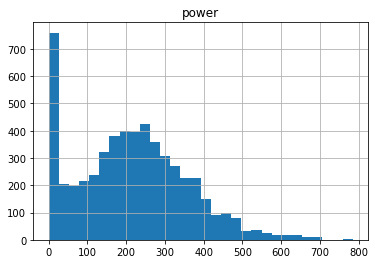

In [124]:
# test if 785 Watt can be detected as an outlier visually

rr19_power_distribution = rr_2019.hist('power', bins=30, histtype='stepfilled')

In [94]:
# show relevant features

rr_2019_distance = rr_2019["distance"].sum()
rr_2019_time = rr_2019["timedelta"].sum()/60
rr_2019_elevation = rr_2019["elevation_gain"].sum()
rr_2019_speed = rr_2019["speed"].mean()
rr_2019_minkm = (rr_2019_time)/rr_2019_distance

print("Total distance travelled for road race in 2019 is:\t", round(rr_2019_distance, 2), "km")
print("Total time needed for road race in 2019 is:\t\t", round(rr_2019_time, 2), "minutes")
print("Total elevation gain for road race in 2019 is:\t\t", round(rr_2019_elevation, 2), "m")
print("The mean speed for road race in 2019 is:\t\t", round(rr_2019_speed, 2), "km/h")
print("The mean time per kilometer for road race in 2019 is:\t", round(rr_2019_minkm, 2), "min/km")

Total distance travelled for road race in 2019 is:	 51.79 km
Total time needed for road race in 2019 is:		 91.7 minutes
Total elevation gain for road race in 2019 is:		 1.4 m
The mean speed for road race in 2019 is:		 33.88 km/h
The mean time per kilometer for road race in 2019 is:	 1.77 min/km


In [75]:
# add simple moving average of speed as a column 

rr_2019["speed_SMA"] = rr_2019["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
rr_2019.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,NaN,0.000000
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0,8.421339
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0,12.737917
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0,15.492916
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0,17.239446


#### 2.3 Time Trial 2016

In [76]:
# overall statistical summary for time trial one in 2016

tt_2016.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,1541.000000,1541.000000,1541.000000,1541.000000,1541.0,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000,1540.000000
mean,-33.368105,151.225411,139.068657,10.953277,0.0,83.277093,170.939650,0.016095,-0.002466,33.529963,1.783766
std,0.028055,0.006166,30.301132,0.657937,0.0,21.169978,23.392548,0.015897,0.515343,11.519681,1.822713
min,-33.418368,151.211206,85.000000,10.000000,0.0,0.000000,100.000000,0.000000,-7.400000,0.000000,1.000000
25%,-33.393795,151.221870,116.200000,11.000000,0.0,77.000000,157.000000,0.007622,-0.400000,25.068271,1.000000
50%,-33.370613,151.227333,134.000000,11.000000,0.0,86.000000,161.000000,0.010974,0.000000,32.840076,1.000000
75%,-33.343332,151.230072,165.400000,11.000000,0.0,96.000000,180.000000,0.015960,0.400000,41.470522,2.000000
max,-33.316888,151.235137,202.600000,13.000000,0.0,118.000000,251.000000,0.288175,2.400000,162.505764,31.000000


Note the following:<br/>
- maximum recorded speed is 162 km/h. This requires further investigation since it is an unusual high speed.
- maximum recorded heart rate is 251 bpm. This requires further investigation since it seems like an impossible value.

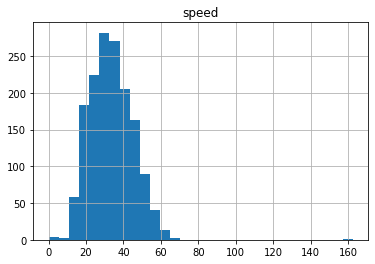

In [121]:
# test if 162km/h can be detected visually as an outlier

tt16_speed_distribution = tt_2016.hist('speed', bins=30, histtype='stepfilled')

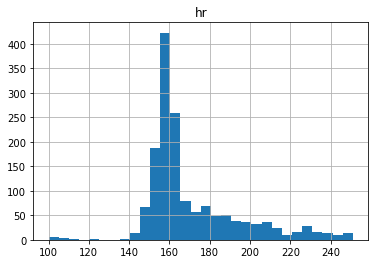

In [122]:
# test if 251 bpm can be detected visually as an outlier

tt16_bpm_distribution = tt_2016.hist('hr', bins=30, histtype='stepfilled')

In [92]:
# show relevant features

tt_2016_distance = tt_2016["distance"].sum()
tt_2016_time = tt_2016["timedelta"].sum()/60
tt_2016_elevation = tt_2016["elevation_gain"].sum()
tt_2016_speed = tt_2016["speed"].mean()
tt_2016_minkm = (tt_2016_time)/tt_2016_distance

print("Total distance travelled for time trial in 2016 is:\t", round(tt_2016_distance, 2), "km")
print("Total time needed for time trial in 2016 is:\t\t", round(tt_2016_time, 2), "minutes")
print("Total elevation gain for time trial in 2016 is:\t\t", round(tt_2016_elevation, 2), "m")
print("The mean speed for time trial in 2016 is:\t\t", round(tt_2016_speed, 2), "km/h")
print("The mean time per kilometer for time trial in 2016 is:\t", round(tt_2016_minkm, 2), "min/km")

Total distance travelled for time trial in 2016 is:	 24.8 km
Total time needed for time trial in 2016 is:		 45.78 minutes
Total elevation gain for time trial in 2016 is:		 -3.8 m
The mean speed for time trial in 2016 is:		 33.53 km/h
The mean time per kilometer for time trial in 2016 is:	 1.85 min/km


In [78]:
# add simple moving average of speed as a column 

tt_2016["speed_SMA"] = tt_2016["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
tt_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.000000,NaN,0.000000
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,11.089134,2.0,5.544567
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,0.991282,6.0,4.026805
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,0.249655,23.0,3.082518
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,5.742071,1.0,3.614428


#### 2.3 Time Trial 2019

In [79]:
# overall statistical summary for time trial two in 2019

tt_2019.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2654.0
mean,-33.368391,151.225397,250.435104,10.194350,257.566855,89.979661,152.741243,0.009183,0.000377,33.057824,1.0
std,0.028682,0.006234,29.434104,0.833934,80.023555,17.543883,8.217632,0.002715,0.298628,9.773522,0.0
min,-33.415798,151.211507,195.800000,9.000000,0.000000,0.000000,88.000000,0.000000,-1.600000,0.000000,1.0
25%,-33.394910,151.221400,229.200000,10.000000,213.500000,88.000000,150.000000,0.007345,-0.200000,26.440757,1.0
50%,-33.370118,151.227363,243.800000,10.000000,264.000000,94.000000,153.000000,0.009228,0.000000,33.220108,1.0
75%,-33.343803,151.230040,276.200000,10.000000,308.000000,98.000000,158.000000,0.010913,0.200000,39.286242,1.0
max,-33.316882,151.235098,312.200000,13.000000,522.000000,111.000000,166.000000,0.017584,0.600000,63.300734,1.0


In [93]:
# show relevant features

tt_2019_distance = tt_2019["distance"].sum()
tt_2019_time = tt_2019["timedelta"].sum()/60
tt_2019_elevation = tt_2019["elevation_gain"].sum()
tt_2019_speed = tt_2019["speed"].mean()
tt_2019_minkm = (tt_2019_time)/tt_2019_distance

print("Total distance travelled for time trial in 2019 is:\t", round(tt_2019_distance, 2), "km")
print("Total time needed for time trial in 2019 is:\t\t", round(tt_2019_time, 2), "minutes")
print("Total elevation gain for time trial in 2019 is:\t\t", round(tt_2019_elevation, 2), "m")
print("The mean speed for time trial in 2019 is:\t\t", round(tt_2019_speed, 2), "km/h")
print("The mean time per kilometer for time trial in 2019 is:\t", round(tt_2019_minkm, 2), "min/km")

Total distance travelled for time trial in 2019 is:	 24.38 km
Total time needed for time trial in 2019 is:		 44.23 minutes
Total elevation gain for time trial in 2019 is:		 1.0 m
The mean speed for time trial in 2019 is:		 33.06 km/h
The mean time per kilometer for time trial in 2019 is:	 1.81 min/km


In [81]:
# add simple moving average of speed as a column 

tt_2019["speed_SMA"] = tt_2019["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
tt_2019.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,NaN,0.000000
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0,3.537828
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0,4.649079
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0,5.255724
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0,5.649378


In [99]:
# comparison of all race metrics

comparison = pd.DataFrame(
    {
        'Race':['rr_2016', 'rr_2019', 'tt_2016', 'tt_2019'],
        'Total_Distance':[rr_2016_distance, rr_2019_distance, tt_2016_distance, tt_2019_distance],
        'Total_Time':[rr_2016_time, rr_2019_time, tt_2016_time, tt_2019_time],
        'Total_Elevation':[rr_2016_elevation, rr_2019_elevation, tt_2016_elevation, tt_2019_elevation],
        'Mean_Speed':[rr_2016_speed, rr_2019_speed, tt_2016_speed, tt_2019_speed],
        'Min_Km':[rr_2016_minkm, rr_2019_minkm, tt_2016_minkm, tt_2019_minkm]
    })
comparison

,Race,Total_Distance,Total_Time,Total_Elevation,Mean_Speed,Min_Km
0,rr_2016,49.048586,86.666667,-10.6,34.933085,1.766955
1,rr_2019,51.789133,91.700000,1.4,33.879861,1.770642
2,tt_2016,24.802887,45.783333,-3.8,33.529963,1.845887
3,tt_2019,24.380145,44.233333,1.0,33.057824,1.814318


#### Part One Summary
As expected, the total distance and time of road races are approximately double the amount compared to time trials. However, it is interesting to see that the average speed is not significantly different among the races. One could expect the shorter races to have an higher average speed. On the contrary, the average time per kilometer is even longer for the time trial races which is a bit surprising.

### 3. Compare the range of speeds for each ride, are time trials faster than road races?

In [127]:
speed_comparison = pd.DataFrame({
    'Speed Statistics':['Mean', 'Median', 'Std. Deviation', 'Maximum', 'SMA'],
    'rr_2016':[rr_2016["speed"].mean(), rr_2016["speed"].median(), rr_2016["speed"].std(), rr_2016["speed"].max(), rr_2016["speed_SMA"].mean()],
    'rr_2019':[rr_2019["speed"].mean(), rr_2019["speed"].median(), rr_2019["speed"].std(), rr_2019["speed"].max(), rr_2019["speed_SMA"].mean()],
    'tt_2016':[tt_2016["speed"].mean(), tt_2016["speed"].median(), tt_2016["speed"].std(), tt_2016["speed"].max(), tt_2016["speed_SMA"].mean()],
    'tt_2019':[tt_2019["speed"].mean(), tt_2019["speed"].median(), tt_2019["speed"].std(), tt_2019["speed"].max(), tt_2019["speed_SMA"].mean()]
    })
speed_comparison

,Speed Statistics,rr_2016,rr_2019,tt_2016,tt_2019
0,Mean,34.933085,33.879861,33.529963,33.057824
1,Median,33.307339,33.041360,32.840076,33.220108
2,Std. Deviation,10.738677,8.853503,11.519681,9.773522
3,Maximum,92.749036,70.370469,162.505764,63.300734
4,SMA,34.760842,33.792255,33.116401,32.730290


### Part Two Summary
As has already been shown in part one, time trials are not faster than road races. However, it can be seen that both races in 2016 were slightly faster on average than their counterparts in 2019. It is also interesting to see that the variance around the mean is higher for both races in 2016. This indicates that both races in 2019 were finished with a higher consistency of speed. 

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.



